# Fully connected Auto-Encoder for Tabular Data
In order to compare the classical and quantum methods we will implement several methods including the deep learning method, fully connected auto-encoder. 

### Imports

In [194]:
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, precision_recall_curve


#Auto-encoder imports
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import bctools as bc

#DataSets that we can test
vowel = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.data'
iris = load_iris()
breast_cancer = load_breast_cancer()

name_datasets_sklearn = {'iris_data': iris, 'breast_cancer_data': breast_cancer}

# TODO: some error because of the location of the file
# from ipynb.fs.full.EDA import vowelData
# from ipynb.fs.full.EDA import irisData
# from ipynb.fs.full.EDA import breastcancerData

### Load data

In [195]:
vowel_data = pd.read_csv(vowel, index_col=False, delim_whitespace=True, header=None)
iris_data = pd.DataFrame(np.concatenate((name_datasets_sklearn["iris_data"]["data"], name_datasets_sklearn["iris_data"]["target"].reshape(-1,1)), axis=1))
breast_cancer_data = pd.DataFrame(np.concatenate((name_datasets_sklearn["breast_cancer_data"]["data"], name_datasets_sklearn["breast_cancer_data"]["target"].reshape(-1,1)), axis=1))
datasets = [vowel_data, iris_data, breast_cancer_data]

In [196]:
def get_dataloaders(dataset, normal_classes, anomaly_classes, batch_size=64, normal_test_percentage=0.1, seed=42):
    normal_data = dataset.copy()
    anomaly_data = dataset.copy()

    normal_data.iloc[:,:-1] = (normal_data.iloc[:,:-1] - normal_data.iloc[:,:-1].mean()) / normal_data.iloc[:,:-1].std()
    anomaly_data.iloc[:,:-1] = (anomaly_data.iloc[:,:-1] - anomaly_data.iloc[:,:-1].mean()) / anomaly_data.iloc[:,:-1].std()

    # isolate normal classes
    normal_data = normal_data[normal_data.iloc[:,-1].isin(normal_classes)].to_numpy()
    normal_data[:,-1] = 0

    # isolate anomaly classes
    anomaly_data = anomaly_data[anomaly_data.iloc[:,-1].isin(anomaly_classes)].to_numpy()
    anomaly_data[:,-1] = 1

    # split the data into train and test with the `normal_test_percentage` of the normal data being in the test set
    # together with all of the anomalies
    len_normal = normal_data.shape[0]
    train_size = int(len_normal * (1-normal_test_percentage))
    test_normal_size = len_normal - train_size

    train_data, test_data = torch.utils.data.random_split(normal_data, [train_size, test_normal_size], generator=torch.Generator().manual_seed(seed))
    test_data = np.concatenate([test_data, anomaly_data])

    train_data = np.array(train_data, dtype=np.float32)
    test_data = np.array(test_data, dtype=np.float32)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    
    return train_loader, test_loader

### Autoencoder

In [197]:
# Define the autoencoder class
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size//4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size//4, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train(self, train_loader, normal_classes, anomaly_classes, n_epochs=50, criterion=nn.MSELoss()):
        optimizer = optim.Adam(self.parameters(), lr=0.005)

        for epoch in range(n_epochs):
            for batch in train_loader:

                X = batch[:, :-1] # drop the label

                # Forward pass
                output = self(X)
                loss = criterion(output, X)
                
                # Backward pass and optimization step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
                
            # Print the loss for this epoch
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

    def get_reconstruction_errors(self, loader):
        diffs = np.array([])
        all_labels = np.array([])
        for data in loader:
            labels = data[:,-1]
            data = data[:,:-1]
            rec_data = self(data)
            rec_error = torch.sum((data - rec_data)**2, axis=1)
            diffs = np.concatenate((diffs, rec_error.detach().numpy()))
            all_labels = np.concatenate((all_labels, labels.detach().numpy()))
        return diffs, all_labels

    def classify(self, loader, threshold):
        errors, labels = self.get_reconstruction_errors(loader)
        preds = np.where(errors > threshold, 1, 0)
        return preds, labels

In [198]:
data = vowel_data
model = AutoEncoder(data.shape[1]-1, 12)
train_loader, test_loader = get_dataloaders(data, [0,1], [2,3])
model.train(train_loader, [0], [8])
errors, labels = model.get_reconstruction_errors(test_loader)
np.mean(errors[labels==0]), np.mean(errors[labels==1])

Epoch [1/50], Loss: 1.6281
Epoch [2/50], Loss: 1.5875
Epoch [3/50], Loss: 1.5415
Epoch [4/50], Loss: 1.4865
Epoch [5/50], Loss: 1.4210
Epoch [6/50], Loss: 1.3445
Epoch [7/50], Loss: 1.2641
Epoch [8/50], Loss: 1.1939
Epoch [9/50], Loss: 1.1349
Epoch [10/50], Loss: 1.0761
Epoch [11/50], Loss: 1.0298
Epoch [12/50], Loss: 0.9980
Epoch [13/50], Loss: 0.9726
Epoch [14/50], Loss: 0.9513
Epoch [15/50], Loss: 0.9304
Epoch [16/50], Loss: 0.9089
Epoch [17/50], Loss: 0.8850
Epoch [18/50], Loss: 0.8606
Epoch [19/50], Loss: 0.8332
Epoch [20/50], Loss: 0.7994
Epoch [21/50], Loss: 0.7607
Epoch [22/50], Loss: 0.7221
Epoch [23/50], Loss: 0.6858
Epoch [24/50], Loss: 0.6521
Epoch [25/50], Loss: 0.6170
Epoch [26/50], Loss: 0.5818
Epoch [27/50], Loss: 0.5504
Epoch [28/50], Loss: 0.5213
Epoch [29/50], Loss: 0.4984
Epoch [30/50], Loss: 0.4827
Epoch [31/50], Loss: 0.4704
Epoch [32/50], Loss: 0.4609
Epoch [33/50], Loss: 0.4512
Epoch [34/50], Loss: 0.4414
Epoch [35/50], Loss: 0.4337
Epoch [36/50], Loss: 0.4270
E

(5.3795240256521435, 8.885595658090379)

In [199]:
model.classify(test_loader, 4.5)

(array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 

In [200]:
def accuracy_score(preds, labels):
    return np.sum(preds == labels)/len(preds)

def precision_score(preds, labels):
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    return tp/(tp + fp)

def recall_score(preds, labels):
    tp = np.sum((preds == 1) & (labels == 1))
    fn = np.sum((preds == 0) & (labels == 1))
    return tp/(tp + fn)

def f1_score(preds, labels):
    prec = precision_score(preds, labels)
    rec = recall_score(preds, labels)
    return 2 * prec * rec / (prec + rec)

def statistics(preds, labels):
    return {
        "accuracy": accuracy_score(preds, labels),
        "precision": precision_score(preds, labels),
        "recall": recall_score(preds, labels),
        "f1": f1_score(preds, labels)
    }

def plot_distribution_reconstruction(preds, labels, title="Reconstruction error distribution"):
    sns.kdeplot(preds[labels==0], shade=True, label="Normal")
    sns.kdeplot(preds[labels==1], shade=True, label="Anomaly")
    plt.xlabel("Reconstruction error")
    plt.ylabel("Density")
    plt.title(title)
    plt.show()
    
def print_statistics(preds, labels):
    stats = statistics(preds, labels)
    print("Accuracy:", stats["accuracy"])
    print("Precision:", stats["precision"])
    print("Recall:", stats["recall"])
    print("F1:", stats["f1"])    

def plot_confusion_matrix(preds, labels):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def get_thresholds_from_predictions(model, dataloader):
    errors, _ = model.get_reconstruction_errors(dataloader)
    return get_thresholds_in_range(np.min(errors), np.max(errors), 100)

def get_thresholds_in_range(min, max, num):
    return np.linspace(min, max, num)

def plot_roc_curve(model, dataloader, thresholds):
    fpr = []
    tpr = []
    for threshold in thresholds:
        preds, labels = model.classify(dataloader, threshold)
        fpr.append(1 - recall_score(preds, labels))
        tpr.append(precision_score(preds, labels))
    plt.plot([0,*fpr,1], [0, *tpr, 1], label="Model")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

def plot_precision_recall_curve(model, dataloader, thresholds):
    precisions = []
    recalls = []
    for threshold in thresholds:
        preds, labels = model.classify(dataloader, threshold)
        precisions.append(precision_score(preds, labels))
        recalls.append(recall_score(preds, labels))
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

def fancy_confusion_plot(preds, labels):
    cf_fig, var_metrics_df, invar_metrics_df, opt_thresh_df = bc.confusion_matrix_plot(
    true_y = labels, 
    predicted_proba = preds, 
    threshold_step = 0.05, 
    title = 'Interactive Confusion Matrix for the Test Set')
    cf_fig.show()

In [201]:
print_statistics(*model.classify(test_loader, 4.5))

Accuracy: 0.8434343434343434
Precision: 0.935672514619883
Recall: 0.8888888888888888
F1: 0.9116809116809117


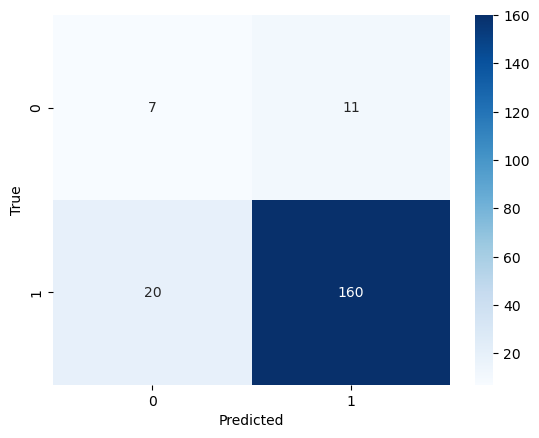

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:7: RuntimeWarning:

invalid value encountered in long_scalars



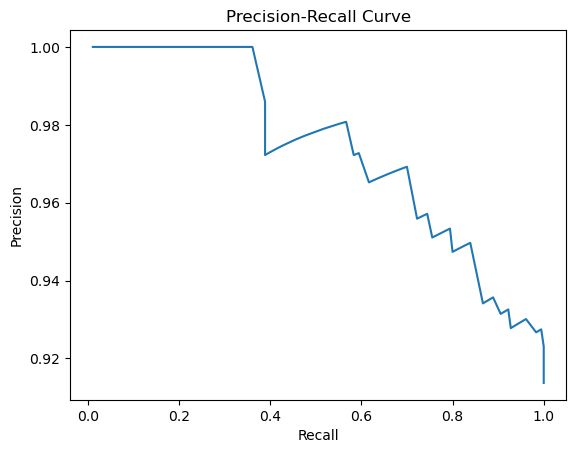

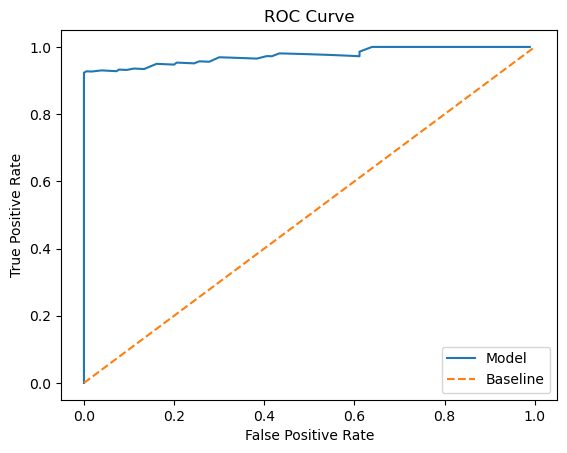

In [202]:
thresholds = get_thresholds_from_predictions(model, test_loader)
plot_confusion_matrix(*model.classify(test_loader, 4.5))
plot_precision_recall_curve(model, test_loader, thresholds)
plot_roc_curve(model, test_loader, thresholds)

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:28: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:29: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




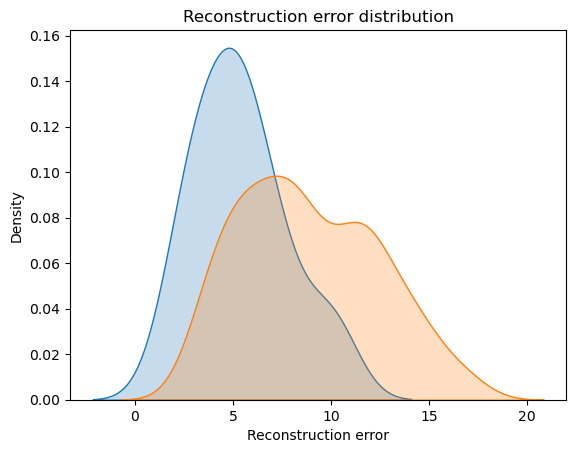

In [203]:
plot_distribution_reconstruction(*model.get_reconstruction_errors(test_loader))

# Combined pipeline

In [204]:
def everything(data, normal_classes, anomaly_classes, normal_test_percentage, threshold, maximum_threshold):
    model = AutoEncoder(data.shape[1]-1, 12)
    train_loader, test_loader = get_dataloaders(data, normal_classes, anomaly_classes, normal_test_percentage=normal_test_percentage)
    model.train(train_loader, normal_classes, anomaly_classes)
    errors, labels = model.get_reconstruction_errors(test_loader)
    print(np.mean(errors[labels==0]), np.mean(errors[labels==1]))
    preds, labels = model.classify(test_loader, threshold)
    print_statistics(preds, labels)
    plot_confusion_matrix(*model.classify(test_loader, 4.5))
    plot_distribution_reconstruction(*model.get_reconstruction_errors(train_loader), "Train")
    plot_distribution_reconstruction(*model.get_reconstruction_errors(test_loader), "Test")
    thresholds = get_thresholds_from_predictions(model, test_loader)
    plot_precision_recall_curve(model, test_loader, thresholds)
    plot_roc_curve(model, test_loader, thresholds)
   # plot_distribution_reconstruction(preds, labels)

## Iris dataset

Epoch [1/50], Loss: 0.9600
Epoch [2/50], Loss: 0.9300
Epoch [3/50], Loss: 0.9041
Epoch [4/50], Loss: 0.8811
Epoch [5/50], Loss: 0.8599
Epoch [6/50], Loss: 0.8404
Epoch [7/50], Loss: 0.8217
Epoch [8/50], Loss: 0.8035
Epoch [9/50], Loss: 0.7850
Epoch [10/50], Loss: 0.7660
Epoch [11/50], Loss: 0.7464
Epoch [12/50], Loss: 0.7262
Epoch [13/50], Loss: 0.7054
Epoch [14/50], Loss: 0.6846
Epoch [15/50], Loss: 0.6644
Epoch [16/50], Loss: 0.6459
Epoch [17/50], Loss: 0.6297
Epoch [18/50], Loss: 0.6160
Epoch [19/50], Loss: 0.6034
Epoch [20/50], Loss: 0.5899
Epoch [21/50], Loss: 0.5739
Epoch [22/50], Loss: 0.5561
Epoch [23/50], Loss: 0.5385
Epoch [24/50], Loss: 0.5237
Epoch [25/50], Loss: 0.5104
Epoch [26/50], Loss: 0.4977
Epoch [27/50], Loss: 0.4846
Epoch [28/50], Loss: 0.4712
Epoch [29/50], Loss: 0.4581
Epoch [30/50], Loss: 0.4453
Epoch [31/50], Loss: 0.4325
Epoch [32/50], Loss: 0.4209
Epoch [33/50], Loss: 0.4097
Epoch [34/50], Loss: 0.3965
Epoch [35/50], Loss: 0.3780
Epoch [36/50], Loss: 0.3580
E

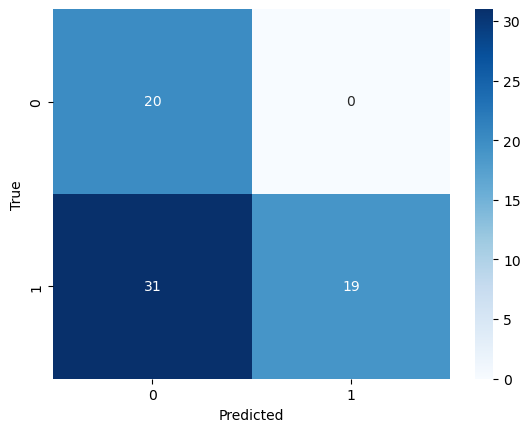

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:28: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:29: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




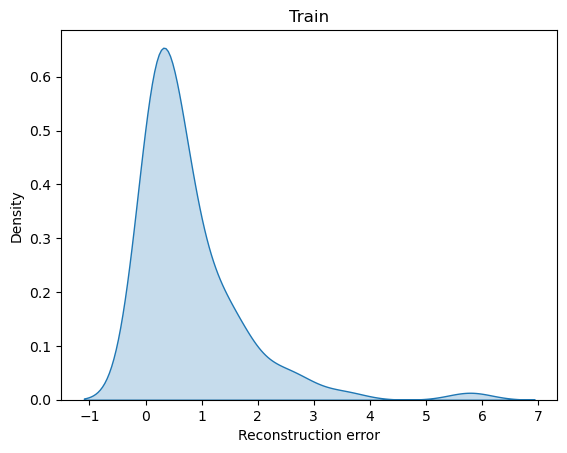

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:28: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:29: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




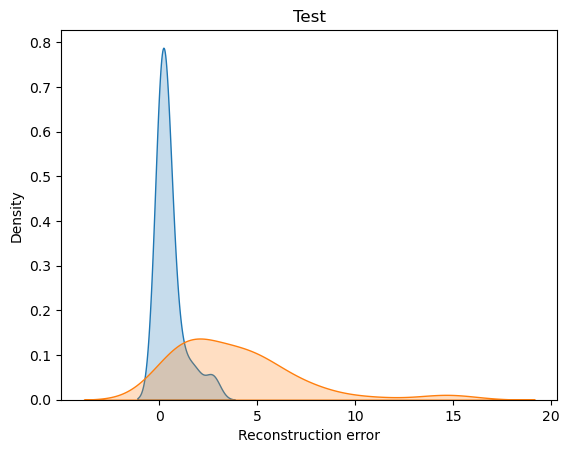

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:7: RuntimeWarning:

invalid value encountered in long_scalars



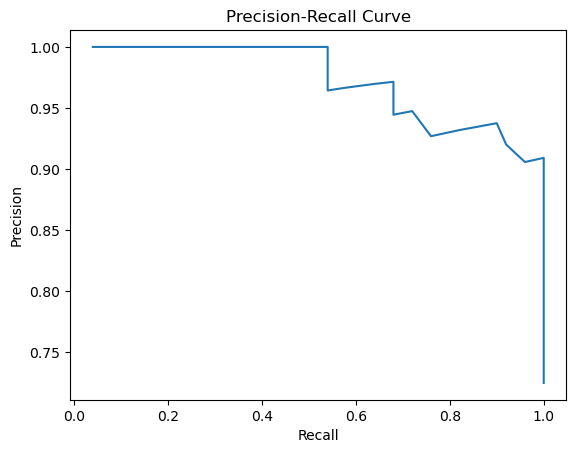

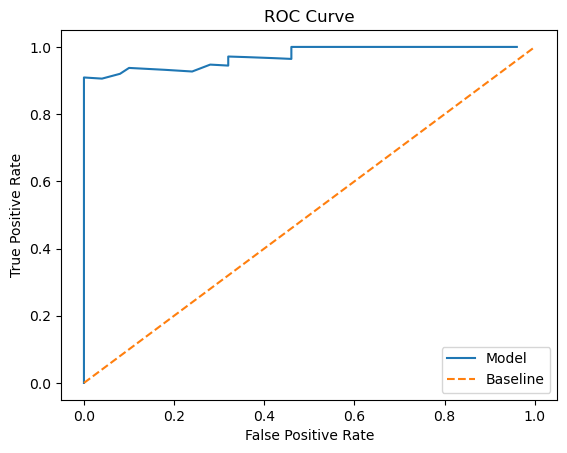

In [205]:
everything(data = iris_data, 
           normal_classes = [0,1],
           anomaly_classes = [2], 
           normal_test_percentage = 0.2,
           threshold = 0.7, 
           maximum_threshold = 10)

### Breast cancer dataset

Epoch [1/50], Loss: 1.4638
Epoch [2/50], Loss: 1.3933
Epoch [3/50], Loss: 1.3097
Epoch [4/50], Loss: 1.2058
Epoch [5/50], Loss: 1.0844
Epoch [6/50], Loss: 0.9699
Epoch [7/50], Loss: 0.8807
Epoch [8/50], Loss: 0.7983
Epoch [9/50], Loss: 0.7242
Epoch [10/50], Loss: 0.6577
Epoch [11/50], Loss: 0.6139
Epoch [12/50], Loss: 0.5787
Epoch [13/50], Loss: 0.5488
Epoch [14/50], Loss: 0.5225
Epoch [15/50], Loss: 0.4975
Epoch [16/50], Loss: 0.4789
Epoch [17/50], Loss: 0.4661
Epoch [18/50], Loss: 0.4537
Epoch [19/50], Loss: 0.4458
Epoch [20/50], Loss: 0.4391
Epoch [21/50], Loss: 0.4323
Epoch [22/50], Loss: 0.4288
Epoch [23/50], Loss: 0.4211
Epoch [24/50], Loss: 0.4164
Epoch [25/50], Loss: 0.4079
Epoch [26/50], Loss: 0.4013
Epoch [27/50], Loss: 0.3918
Epoch [28/50], Loss: 0.3834
Epoch [29/50], Loss: 0.3743
Epoch [30/50], Loss: 0.3660
Epoch [31/50], Loss: 0.3587
Epoch [32/50], Loss: 0.3523
Epoch [33/50], Loss: 0.3480
Epoch [34/50], Loss: 0.3420
Epoch [35/50], Loss: 0.3374
Epoch [36/50], Loss: 0.3326
E

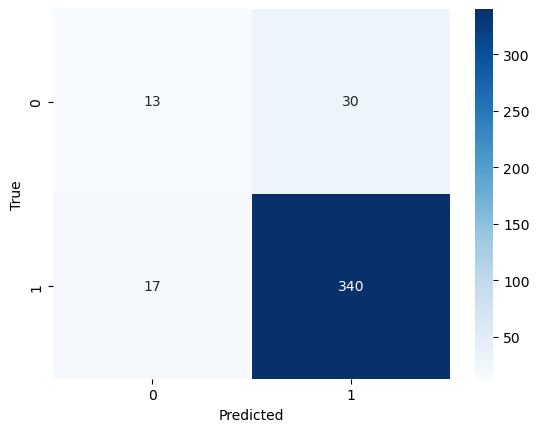

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:28: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:29: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




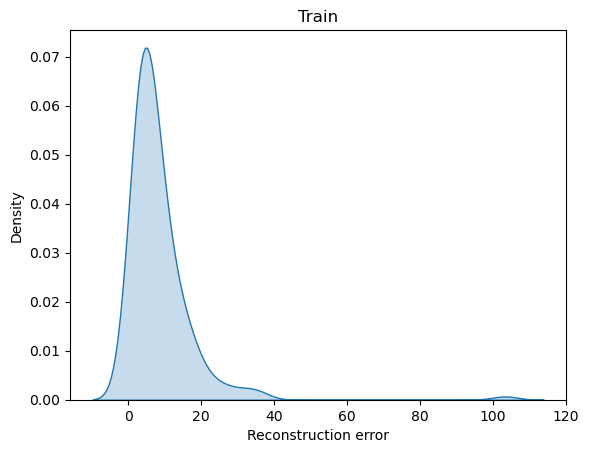

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:28: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:29: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




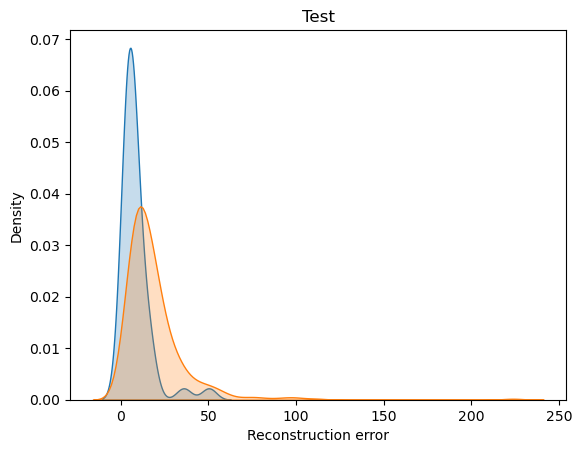

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:7: RuntimeWarning:

invalid value encountered in long_scalars



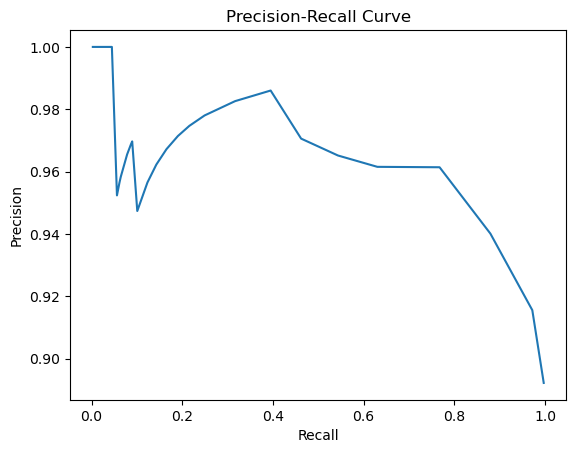

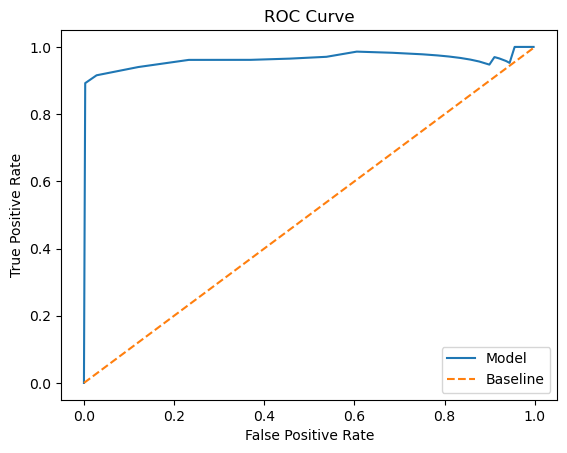

In [206]:
everything(data = breast_cancer_data, 
           normal_classes = [0],
           anomaly_classes = [1], 
           normal_test_percentage = 0.2,
           threshold = 0.5, 
           maximum_threshold = 10)

In [207]:
"""
Look at the distribution of the reconstruction errors for the normal and anomalous classes.
Contruct two distributions and see what the overlap is.
If gaussian, use formula > intersection of gaussians


For different thresholds, plot the precision-recall curve.

Normalize data

Check for papers of anomaly detection on the datasets

Else: Initial tests show that this is reasonable

Add sliders to confusion matrix
"""

'\nLook at the distribution of the reconstruction errors for the normal and anomalous classes.\nContruct two distributions and see what the overlap is.\nIf gaussian, use formula > intersection of gaussians\n\n\nFor different thresholds, plot the precision-recall curve.\n\nNormalize data\n\nCheck for papers of anomaly detection on the datasets\n\nElse: Initial tests show that this is reasonable\n\nAdd sliders to confusion matrix\n'

### Vowel Dataset

Epoch [1/50], Loss: 1.4788
Epoch [2/50], Loss: 1.4289
Epoch [3/50], Loss: 1.3763
Epoch [4/50], Loss: 1.3234
Epoch [5/50], Loss: 1.2721
Epoch [6/50], Loss: 1.2254
Epoch [7/50], Loss: 1.1907
Epoch [8/50], Loss: 1.1686
Epoch [9/50], Loss: 1.1480
Epoch [10/50], Loss: 1.1256
Epoch [11/50], Loss: 1.1040
Epoch [12/50], Loss: 1.0774
Epoch [13/50], Loss: 1.0399
Epoch [14/50], Loss: 0.9951
Epoch [15/50], Loss: 0.9416
Epoch [16/50], Loss: 0.8781
Epoch [17/50], Loss: 0.8119
Epoch [18/50], Loss: 0.7405
Epoch [19/50], Loss: 0.6786
Epoch [20/50], Loss: 0.6323
Epoch [21/50], Loss: 0.6106
Epoch [22/50], Loss: 0.6031
Epoch [23/50], Loss: 0.5917
Epoch [24/50], Loss: 0.5840
Epoch [25/50], Loss: 0.5806
Epoch [26/50], Loss: 0.5723
Epoch [27/50], Loss: 0.5580
Epoch [28/50], Loss: 0.5387
Epoch [29/50], Loss: 0.5188
Epoch [30/50], Loss: 0.4984
Epoch [31/50], Loss: 0.4783
Epoch [32/50], Loss: 0.4592
Epoch [33/50], Loss: 0.4444
Epoch [34/50], Loss: 0.4316
Epoch [35/50], Loss: 0.4200
Epoch [36/50], Loss: 0.4115
E

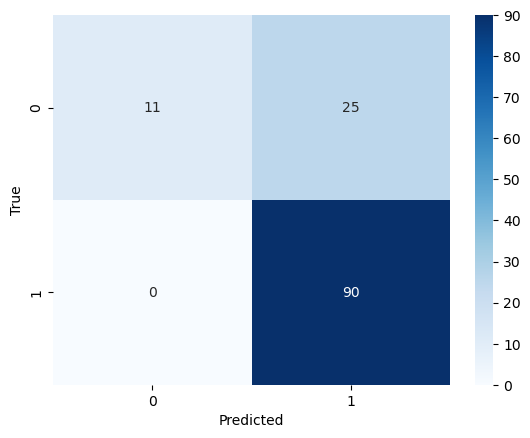

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:28: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:29: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




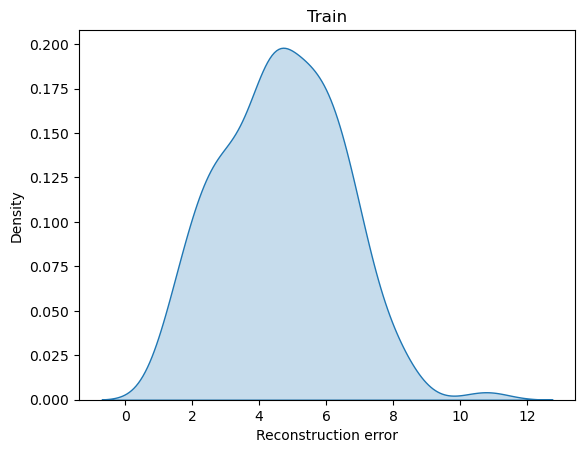

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:28: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:29: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




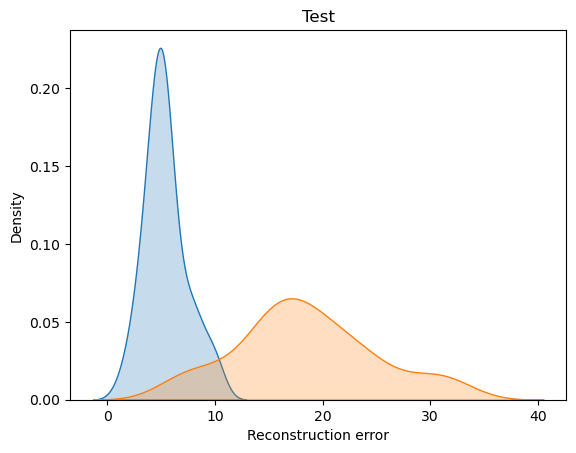

/var/folders/fd/1_gwdh157ld24c3lps0p80br0000gn/T/ipykernel_44180/663984875.py:7: RuntimeWarning:

invalid value encountered in long_scalars



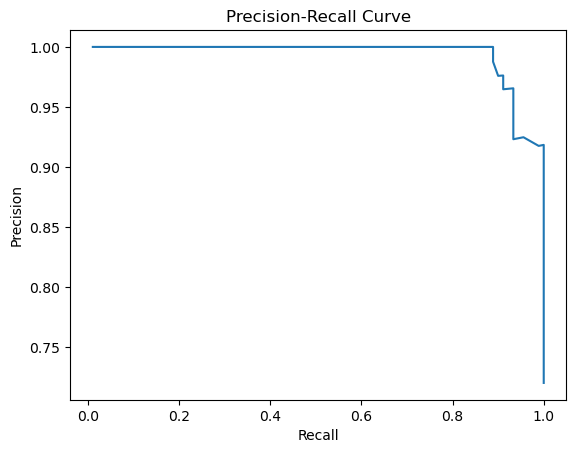

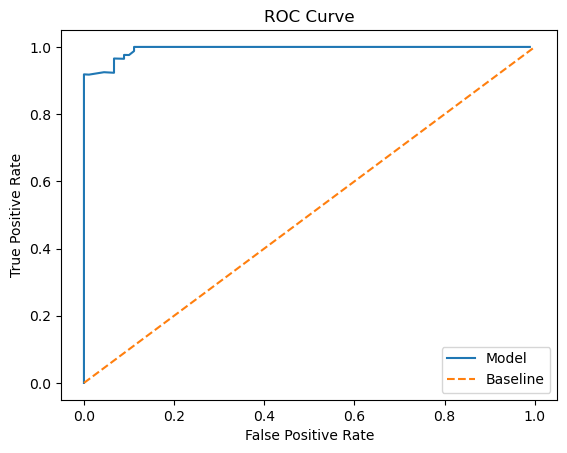

In [208]:
everything(data = vowel_data,
           normal_classes = [0,1],
           anomaly_classes = [8], 
           normal_test_percentage = 0.2,
           threshold = 4.5, 
           maximum_threshold = 10)